# Prepare Item Matrix

In [58]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

In [2]:
raw = pd.read_json("all_output.json")
raw["id"] = raw["url"].apply(lambda url: url.split("/")[-1])
raw["joined"] = raw["joined"].apply(lambda joined: joined.split("Joined ")[1])
raw = raw.drop(columns=["url"])
raw.head()

,categories,joined,name,price,reactions,stars,id
0,"[Reality TV, Commentators, Featured]",April 2018,Perez Hilton,27.0,924,5.0,perezhilton
1,"[Reality TV, Comedians, Featured, Actors]",October 2018,Andy Dick,99.0,340,4.9,andydick
2,"[Reality TV, Riders, Featured, Extreme Sports,...",February 2018,TJ Lavin,80.0,291,5.0,tjlavin
3,"[Reality TV, Bravo, Stylists, Featured, Actors...",October 2018,Carson Kressley,59.0,290,5.0,carsonkressley
4,"[Rappers, Featured, Musicians]",December 2017,RiFF RAFF,75.0,402,4.7,riffraff


In [3]:
import re
from unidecode import unidecode
from sklearn.preprocessing import MultiLabelBinarizer


def clean_column_name(name):
    old = unidecode(name.casefold())
    clean = re.sub("[^0-9a-zA-Z]+", '_', old)
    out = "in_" + clean
    return out


mlb = MultiLabelBinarizer()
mlb.fit(raw["categories"])
one_hot = mlb.transform(raw["categories"])
READABLE_LABELS = list(mlb.classes_)
COLUMN_LABELS = [clean_column_name(label) for label in READABLE_LABELS]
mat = pd.DataFrame(one_hot, columns=COLUMN_LABELS)
mat.head()

,in_13_reasons_why,in_90_day_fiance,in_actors,in_adult_film_stars,in_american_idol,in_animals,in_artists,in_athletes,in_authors,in_baseball,...,in_ufc,in_vanderpump_rules,in_venture_capitalists,in_viners,in_vlog_squad,in_voice_actors,in_winter_sports,in_writers,in_younow,in_youtubers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df = raw.join(mat)
ATTRIBUTES = ["id", "name", "price", "reactions", "stars", "joined", "categories"]
columns = ATTRIBUTES + COLUMN_LABELS
df = df[columns]
df = df.drop_duplicates(subset=["id"], keep="first")
df.head()

,id,name,price,reactions,stars,joined,categories,in_13_reasons_why,in_90_day_fiance,in_actors,...,in_ufc,in_vanderpump_rules,in_venture_capitalists,in_viners,in_vlog_squad,in_voice_actors,in_winter_sports,in_writers,in_younow,in_youtubers
0,perezhilton,Perez Hilton,27.0,924,5.0,April 2018,"['Reality TV', 'Commentators', 'Featured']",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,andydick,Andy Dick,99.0,340,4.9,October 2018,"['Reality TV', 'Comedians', 'Featured', 'Actors']",0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,tjlavin,TJ Lavin,80.0,291,5.0,February 2018,"['Reality TV', 'Riders', 'Featured', 'Extreme ...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,carsonkressley,Carson Kressley,59.0,290,5.0,October 2018,"['Reality TV', 'Bravo', 'Stylists', 'Featured'...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,riffraff,RiFF RAFF,75.0,402,4.7,December 2017,"['Rappers', 'Featured', 'Musicians']",0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
records = df.to_dict(orient="records")
for record in records:
    record["categories"] = literal_eval(record["categories"])
    for col in COLUMN_LABELS:
        if record[col] == 0:
            del record[col]
print("Converted {} rows to sparse records.".format(len(records)))

Converted 5392 rows to sparse records.


In [61]:
import pickle


filename = "talent.pkl"
pickle.dump((records, COLUMN_LABELS, READABLE_LABELS, ATTRIBUTES), open(filename, "wb"))
print("Wrote {} records and metadata to: {}.".format(len(df), filename))

Wrote 5392 records and metadata to: talent.pkl.


In [62]:
# Example of reading the data
item_records, cols, labels, attrs = pickle.load(open(filename, "rb"))
new_df = pd.DataFrame(item_records)[attrs + cols].fillna(value=0)
new_df.head(3)

,id,name,price,reactions,stars,joined,categories,in_13_reasons_why,in_90_day_fiance,in_actors,...,in_ufc,in_vanderpump_rules,in_venture_capitalists,in_viners,in_vlog_squad,in_voice_actors,in_winter_sports,in_writers,in_younow,in_youtubers
0,perezhilton,Perez Hilton,27.0,924,5.0,April 2018,"[Reality TV, Commentators, Featured]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,andydick,Andy Dick,99.0,340,4.9,October 2018,"[Reality TV, Comedians, Featured, Actors]",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tjlavin,TJ Lavin,80.0,291,5.0,February 2018,"[Reality TV, Riders, Featured, Extreme Sports,...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


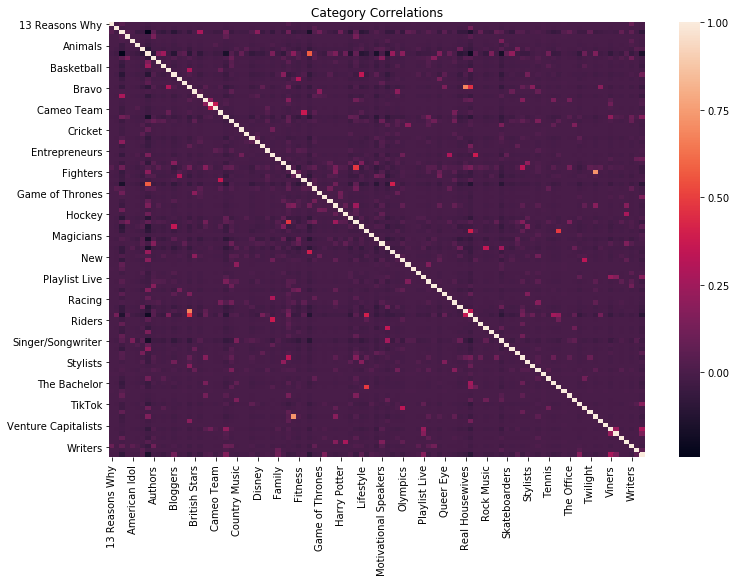

In [7]:
sns.heatmap(pd.DataFrame(mat.copy().values, columns=READABLE_LABELS).corr())
plt.gcf().set_size_inches((12, 8))
plt.title("Category Correlations")
plt.show()

In [8]:
df[ATTRIBUTES].sort_values(by=["reactions"], ascending=False).head(10)

,id,name,price,reactions,stars,joined,categories
9,laturtle,Evan Breen,25.0,1454,4.9,August 2017,"[Viners, Featured]"
0,perezhilton,Perez Hilton,27.0,924,5.0,April 2018,"[Reality TV, Commentators, Featured]"
11,nickcolletti,Nick Colletti,69.0,880,4.9,June 2017,"[YouTubers, Viners, Featured]"
4720,chelcielynn,Chelcie Lynn,30.0,850,5.0,January 2018,"[YouTubers, Viners, For Charity]"
149,codyko,Cody Ko,99.0,684,4.9,February 2017,"[YouTubers, Comedians, Viners, Featured, Brows..."
12,sonjatmorgan,Sonja Morgan,99.0,633,4.8,August 2017,"[Reality TV, Bravo, Featured, Browse Featured,..."
54,todrick,Todrick Hall,45.0,596,5.0,July 2018,"[YouTubers, Reality TV, Bravo, Featured, Drag ..."
7214,toborowsky_david,David & Annie,27.0,537,5.0,October 2018,"[Reality TV, 90 Day Fiancé]"
3068,naphil_hd,I'm Tyrone,70.0,532,5.0,November 2017,"[Comedians, Instagram Influencers]"
178,nikkiblonsky,Nikki Blonsky,20.0,453,4.9,May 2018,"[Broadway, Actors]"
